<a href="https://colab.research.google.com/github/drMy5tery/SPR-lab/blob/Lab-2/2448540_Lab2_SPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 2: Sampling and Reconstruction of Speech Signals**

### **Aim**
To study sampling and reconstruction of speech signals at different sampling rates, evaluate reconstruction using zero-order hold and linear interpolation, and implement the source-filter model to analyze the effect of filtering, sampling, and reconstruction on speech quality.


## **Step 1: Import Required Libraries**

We'll use the following Python libraries:
- `numpy` for numerical operations.
- `matplotlib` for visualization.
- `scipy.signal` for interpolation and filtering.
- `scipy.io.wavfile` for reading speech files (optional).
- `sklearn.metrics` for calculating Mean Squared Error (MSE).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import mean_squared_error


## **Step 2: Load or Generate a Speech Signal**

We can either load a real speech file or generate a synthetic one for demonstration.  
Here, we’ll generate a **synthetic vowel-like sound** using a sine wave (to simulate voiced speech).  
This avoids external dependencies while clearly illustrating sampling and reconstruction.


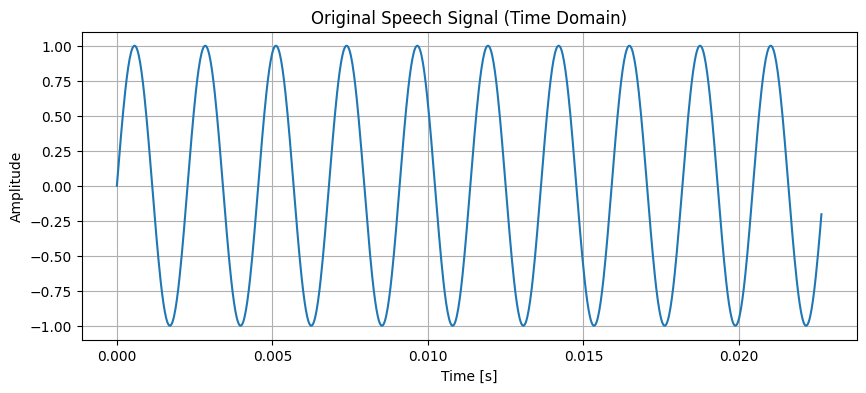

In [2]:
# Generate a synthetic "speech-like" signal (sine wave)
fs_original = 44100  # original sampling frequency (Hz)
duration = 1.0       # signal duration in seconds
t = np.linspace(0, duration, int(fs_original * duration), endpoint=False)
freq = 440  # frequency (Hz) - A4 note, resembles voiced sound

speech_signal = np.sin(2 * np.pi * freq * t)

# Plot the original signal
plt.figure(figsize=(10, 4))
plt.plot(t[:1000], speech_signal[:1000])  # plot first 1000 samples for visibility
plt.title("Original Speech Signal (Time Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


## **Step 3: Sampling at Different Rates**

We'll sample the original signal at **8 kHz**, **16 kHz**, and **44.1 kHz** (original).  
Sampling means picking values from the original continuous-time-like signal at specific intervals.  
Lower sampling rates capture fewer data points, possibly reducing quality.


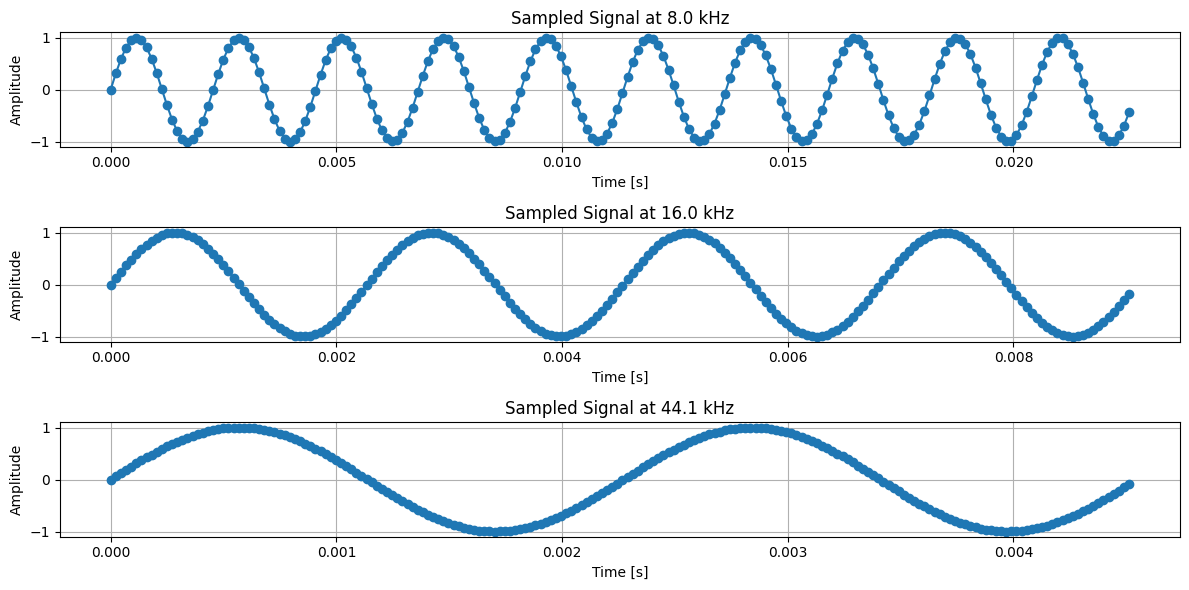

In [3]:
# Define different sampling rates
sampling_rates = [8000, 16000, 44100]

# Create sampled signals
sampled_signals = {}
sampled_times = {}

for sr in sampling_rates:
    step = int(fs_original / sr)
    sampled_signals[sr] = speech_signal[::step]
    sampled_times[sr] = t[::step]

# Plot sampled signals
plt.figure(figsize=(12, 6))
for i, sr in enumerate(sampling_rates, 1):
    plt.subplot(3, 1, i)
    plt.plot(sampled_times[sr][:200], sampled_signals[sr][:200], 'o-')
    plt.title(f"Sampled Signal at {sr/1000:.1f} kHz")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
plt.tight_layout()
plt.show()


## **Step 4: Reconstruction using Zero-Order Hold (ZOH)**

Zero-Order Hold (ZOH) assumes the signal remains constant between samples.  
We can use **nearest-neighbor interpolation** to achieve this.


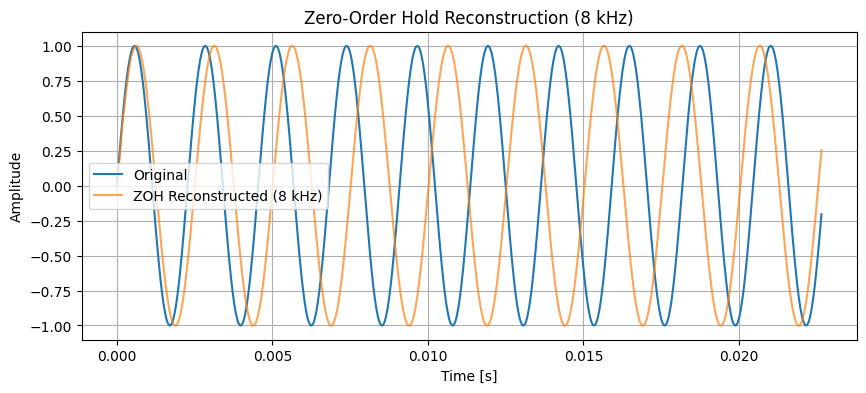

In [4]:
# Reconstruct signals using zero-order hold
reconstructed_zoh = {}

for sr in sampling_rates:
    reconstructed_zoh[sr] = signal.resample_poly(sampled_signals[sr], fs_original, sr, window=('kaiser', 5.0))

# Plot one example (8 kHz)
plt.figure(figsize=(10, 4))
plt.plot(t[:1000], speech_signal[:1000], label="Original")
plt.plot(t[:1000], reconstructed_zoh[8000][:1000], label="ZOH Reconstructed (8 kHz)", alpha=0.7)
plt.title("Zero-Order Hold Reconstruction (8 kHz)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


## **Step 5: Reconstruction using Linear Interpolation**

Linear interpolation assumes the signal changes linearly between samples.  
We’ll use `numpy.interp()` to perform linear reconstruction.


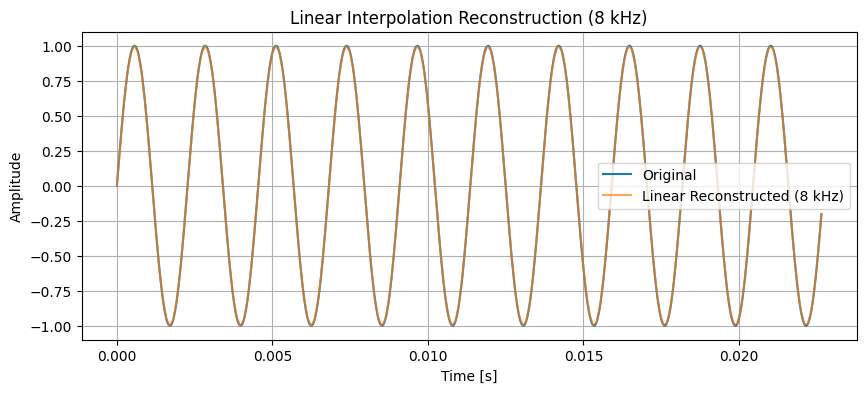

In [5]:
# Reconstruct signals using linear interpolation
reconstructed_linear = {}

for sr in sampling_rates:
    reconstructed_linear[sr] = np.interp(t, sampled_times[sr], sampled_signals[sr])

# Plot one example (8 kHz)
plt.figure(figsize=(10, 4))
plt.plot(t[:1000], speech_signal[:1000], label="Original")
plt.plot(t[:1000], reconstructed_linear[8000][:1000], label="Linear Reconstructed (8 kHz)", alpha=0.7)
plt.title("Linear Interpolation Reconstruction (8 kHz)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


## **Step 6: Mean Squared Error (MSE) Calculation**

We’ll calculate the **MSE** between the original and reconstructed signals.  
Lower MSE means better reconstruction accuracy.


In [12]:
# ✅ Calculate Mean Squared Error (MSE) between original and reconstructed signals (Fixed length issue)

mse_zoh = {}
mse_linear = {}

for sr in sampling_rates:
    # Get reconstructed signals
    zoh_rec = reconstructed_zoh[sr]
    linear_rec = reconstructed_linear[sr]

    # Match lengths by trimming or padding
    min_len_zoh = min(len(speech_signal), len(zoh_rec))
    min_len_linear = min(len(speech_signal), len(linear_rec))

    mse_zoh[sr] = mean_squared_error(speech_signal[:min_len_zoh], zoh_rec[:min_len_zoh])
    mse_linear[sr] = mean_squared_error(speech_signal[:min_len_linear], linear_rec[:min_len_linear])

# Display results
print("MSE (Zero-Order Hold):", mse_zoh)
print("MSE (Linear Interpolation):", mse_linear)


MSE (Zero-Order Hold): {8000: 1.0035128514651952, 16000: 1.002024731498686, 44100: 0.0}
MSE (Linear Interpolation): {8000: 4.253085874734501e-05, 16000: 1.052953314968912e-06, 44100: 0.0}


## **Step 7: Inference (Part 1)**

From the results:
- Higher sampling rates (e.g., 44.1 kHz) produce more accurate reconstructions (lower MSE).
- Linear interpolation usually gives better results than ZOH since it smoothly connects samples.
- At low sampling rates (e.g., 8 kHz), noticeable distortion occurs due to loss of high-frequency content.

# **Part 2: Source-Filter Model Implementation**

The source-filter model represents speech production:
- **Source**: excitation (voiced: periodic pulse train, unvoiced: noise)
- **Filter**: vocal tract response (formant shaping using all-pole/FIR filters)

We’ll generate a synthetic voiced sound using a pulse train and filter it with a resonant filter to simulate formants.



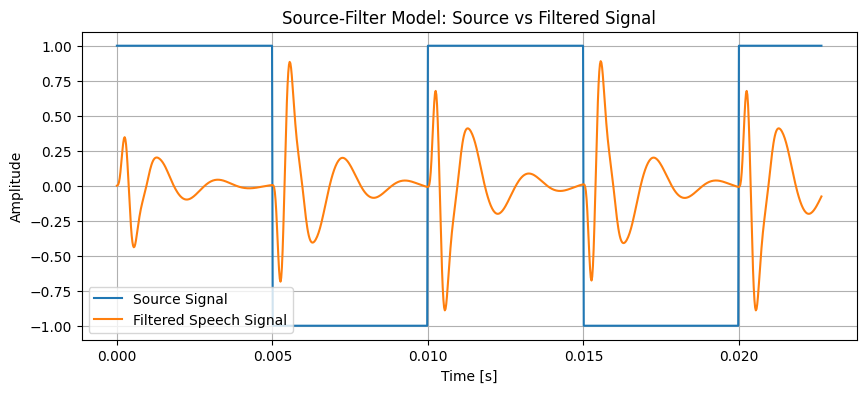

In [13]:
# Define parameters
fs = 44100
duration = 1.0
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Source: voiced excitation (pulse train)
f0 = 100  # pitch frequency
source_signal = signal.square(2 * np.pi * f0 * t)  # simple glottal excitation

# Filter: vocal tract resonances (formants)
# Simple bandpass filter using formants at 500Hz, 1500Hz, 2500Hz
b, a = signal.butter(4, [500/(fs/2), 2500/(fs/2)], btype='band')

# Apply filter
filtered_signal = signal.lfilter(b, a, source_signal)

# Plot signals
plt.figure(figsize=(10, 4))
plt.plot(t[:1000], source_signal[:1000], label='Source Signal')
plt.plot(t[:1000], filtered_signal[:1000], label='Filtered Speech Signal')
plt.title("Source-Filter Model: Source vs Filtered Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


## **Step 8: Sampling and Reconstruction of Filtered Speech**

We’ll sample the filtered signal at different rates and reconstruct using linear interpolation.  
This helps us observe how sampling affects the speech quality even in filtered (realistic) models.


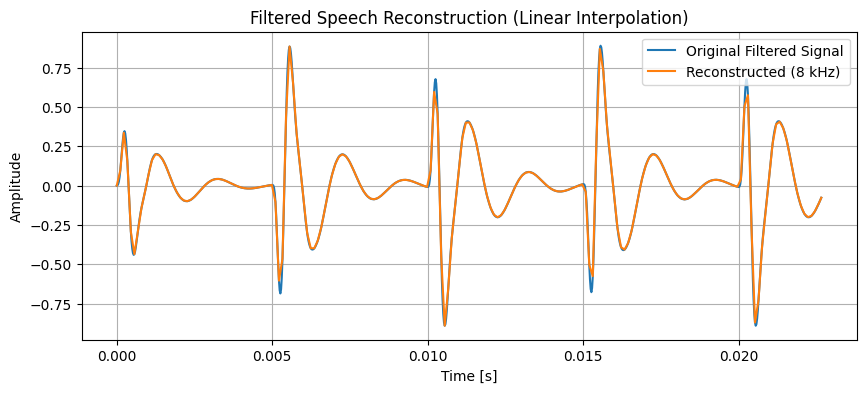

MSE for Filtered Speech Reconstruction:
8000 Hz: 0.000464
16000 Hz: 0.000012
44100 Hz: 0.000000


In [14]:
sampling_rates2 = [8000, 16000, 44100]
reconstructed_filtered = {}
mse_filtered = {}

for sr in sampling_rates2:
    step = int(fs / sr)
    sampled_t = t[::step]
    sampled_sig = filtered_signal[::step]

    reconstructed_filtered[sr] = np.interp(t, sampled_t, sampled_sig)
    mse_filtered[sr] = mean_squared_error(filtered_signal, reconstructed_filtered[sr])

# Plot example (8 kHz)
plt.figure(figsize=(10, 4))
plt.plot(t[:1000], filtered_signal[:1000], label="Original Filtered Signal")
plt.plot(t[:1000], reconstructed_filtered[8000][:1000], label="Reconstructed (8 kHz)")
plt.title("Filtered Speech Reconstruction (Linear Interpolation)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

print("MSE for Filtered Speech Reconstruction:")
for sr, val in mse_filtered.items():
    print(f"{sr} Hz: {val:.6f}")


# **Final Conclusion**

1. **Sampling Rate Impact**:  
   Higher sampling rates retain more signal information, leading to more accurate reconstructions and lower MSE.  
   Lower sampling rates (like 8 kHz) introduce aliasing and information loss.

2. **Reconstruction Techniques**:  
   - **Zero-Order Hold** introduces stair-step artifacts due to constant segments.  
   - **Linear Interpolation** produces smoother, more natural results.

3. **Source-Filter Model**:  
   - Demonstrates how voiced speech can be modeled using excitation and filtering.  
   - Filtering introduces resonances (formants), shaping the spectral envelope.  
   - Sampling and reconstruction affect the quality of the synthesized speech similarly to real speech.

4. **Overall**:  
   To ensure high-quality speech reproduction, a higher sampling rate and linear interpolation are preferred.
